## Take a circuit, Transpile then Find cuts using Automatic Cut Finder

### Draw The Circuit

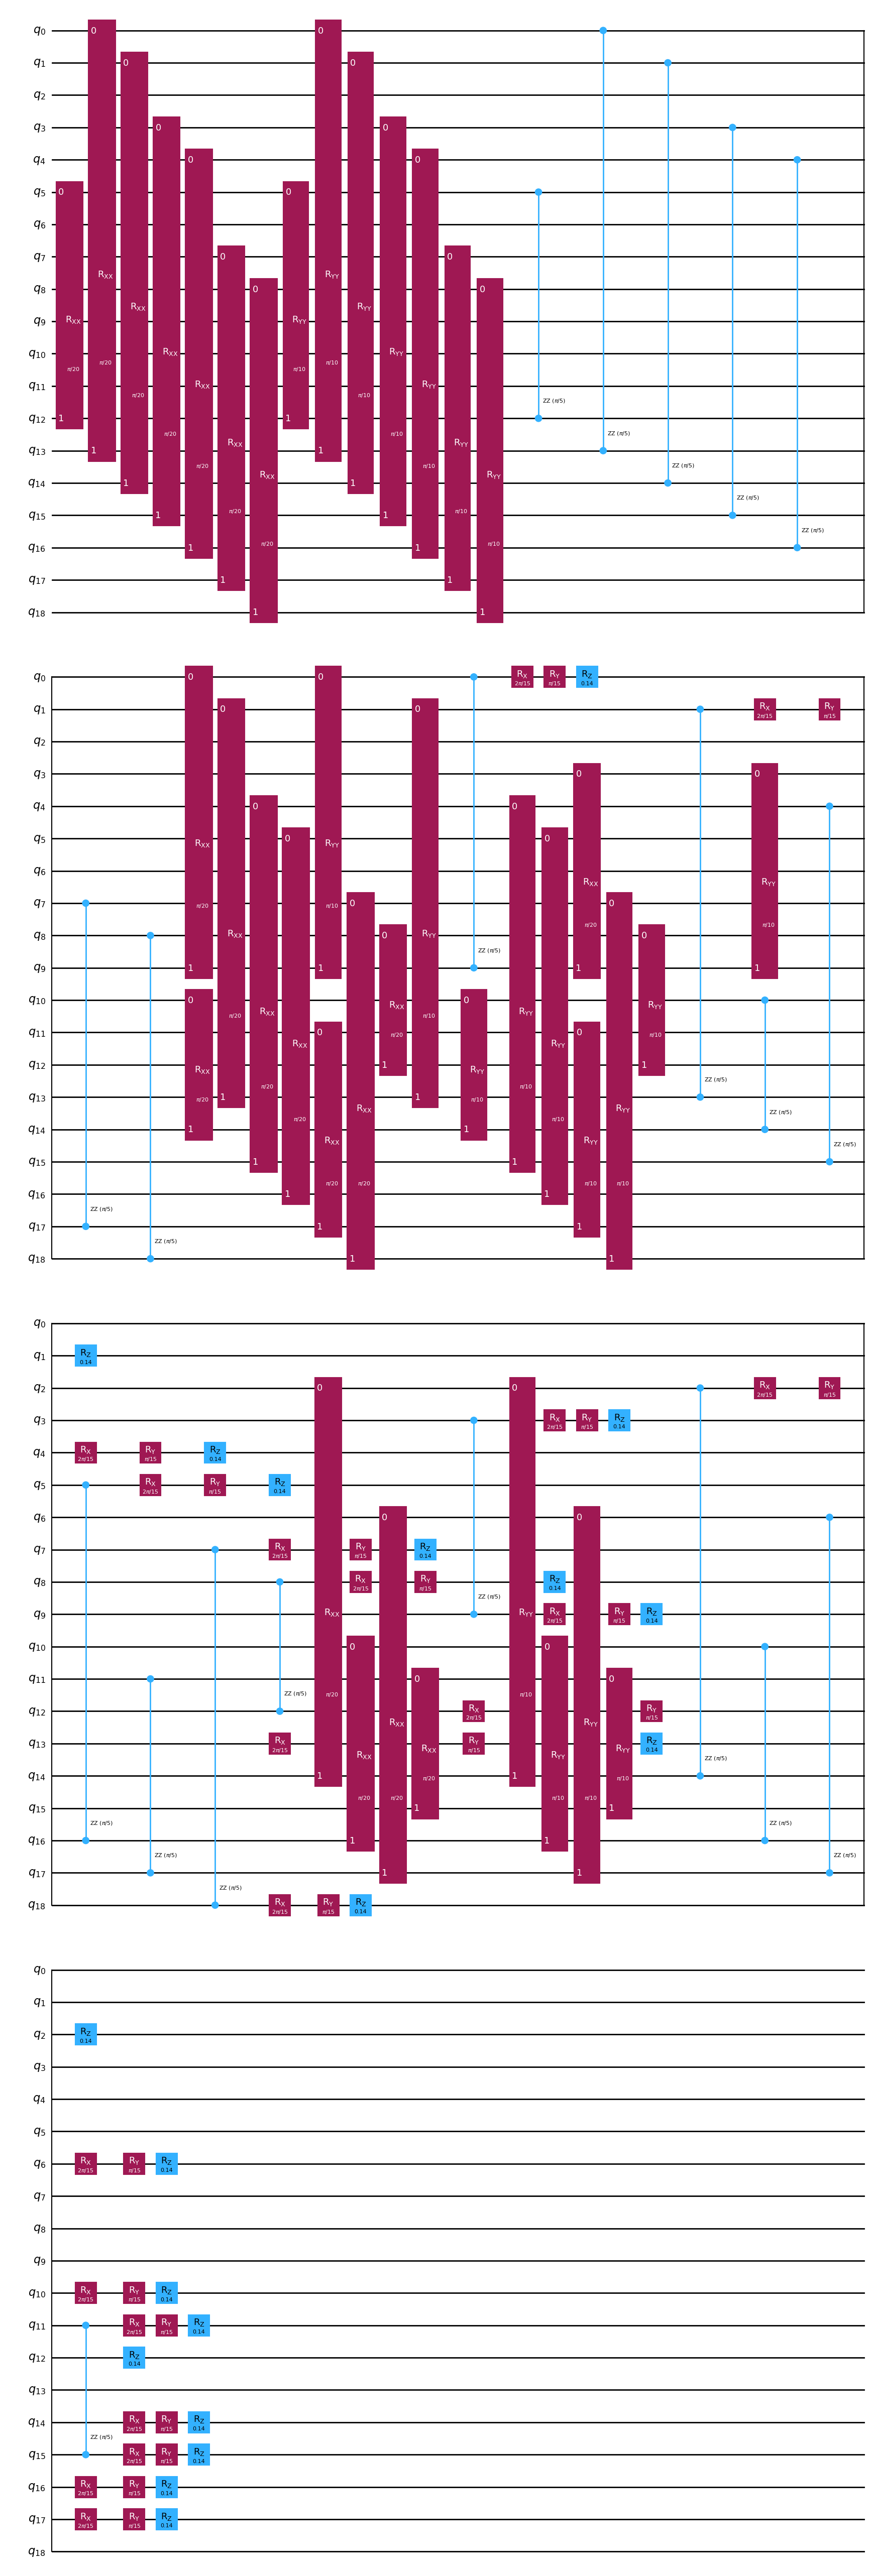

In [129]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=True)

#reduced_coupling_map = coupling_map.reduce(
#    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18, 7, 17, 11, 15, 3]
#)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=1), time=0.2
)


circuit.draw("mpl")

### Specify an Observable

In [130]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j])


### Choose a backend

In [131]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

### Synthesize the Circuit

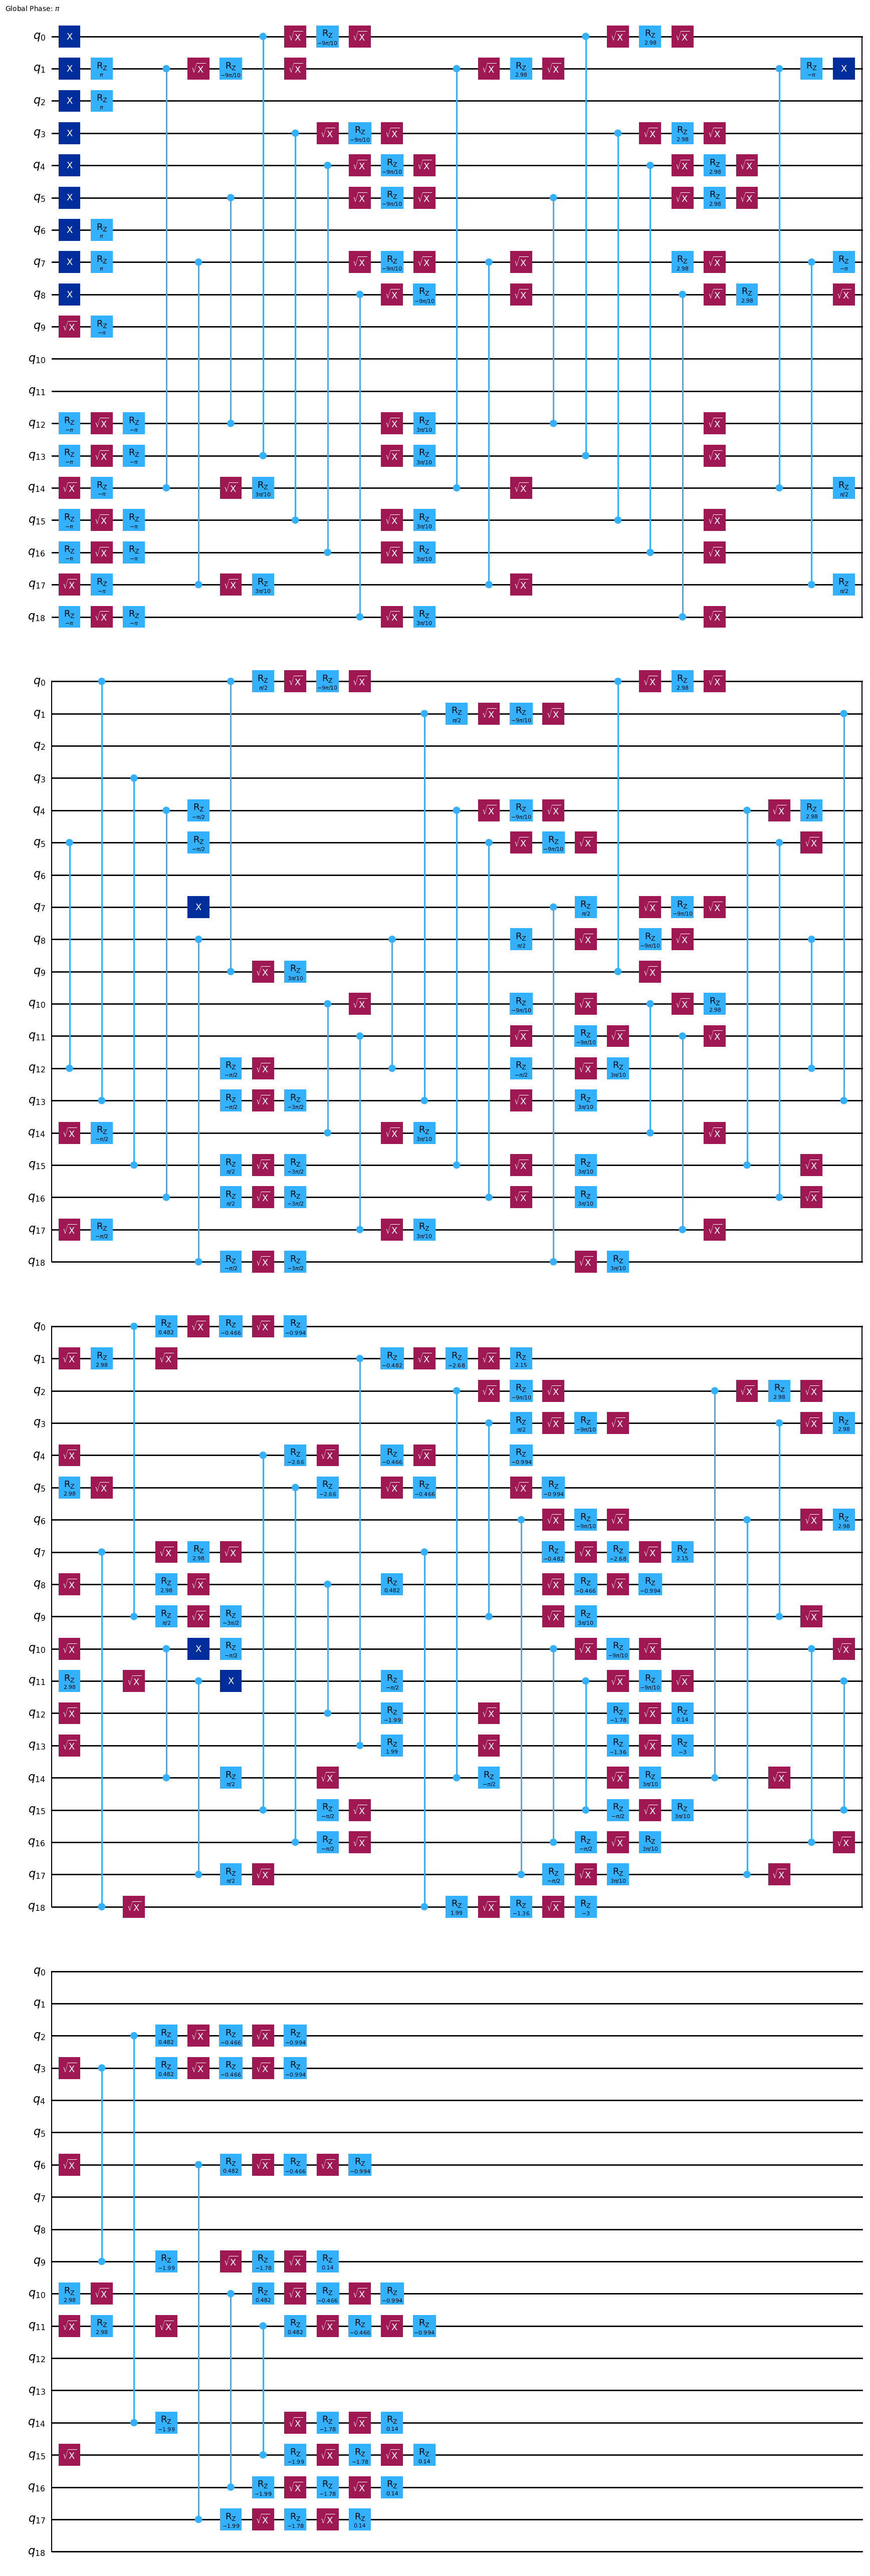

In [132]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

In [133]:
print(" The depth of the synthesized circuit is : ",synth_circuit.depth() )

 The depth of the synthesized circuit is :  40


In [134]:
(synth_circuit.num_qubits/2)+1

10.5

### Giving the circuit to Automatic Cut Finder

Found solution using 3 cuts with a sampling overhead of 4096.0.
Lowest cost solution found: True.
Wire Cut at circuit instruction index 210
Wire Cut at circuit instruction index 252
Wire Cut at circuit instruction index 334


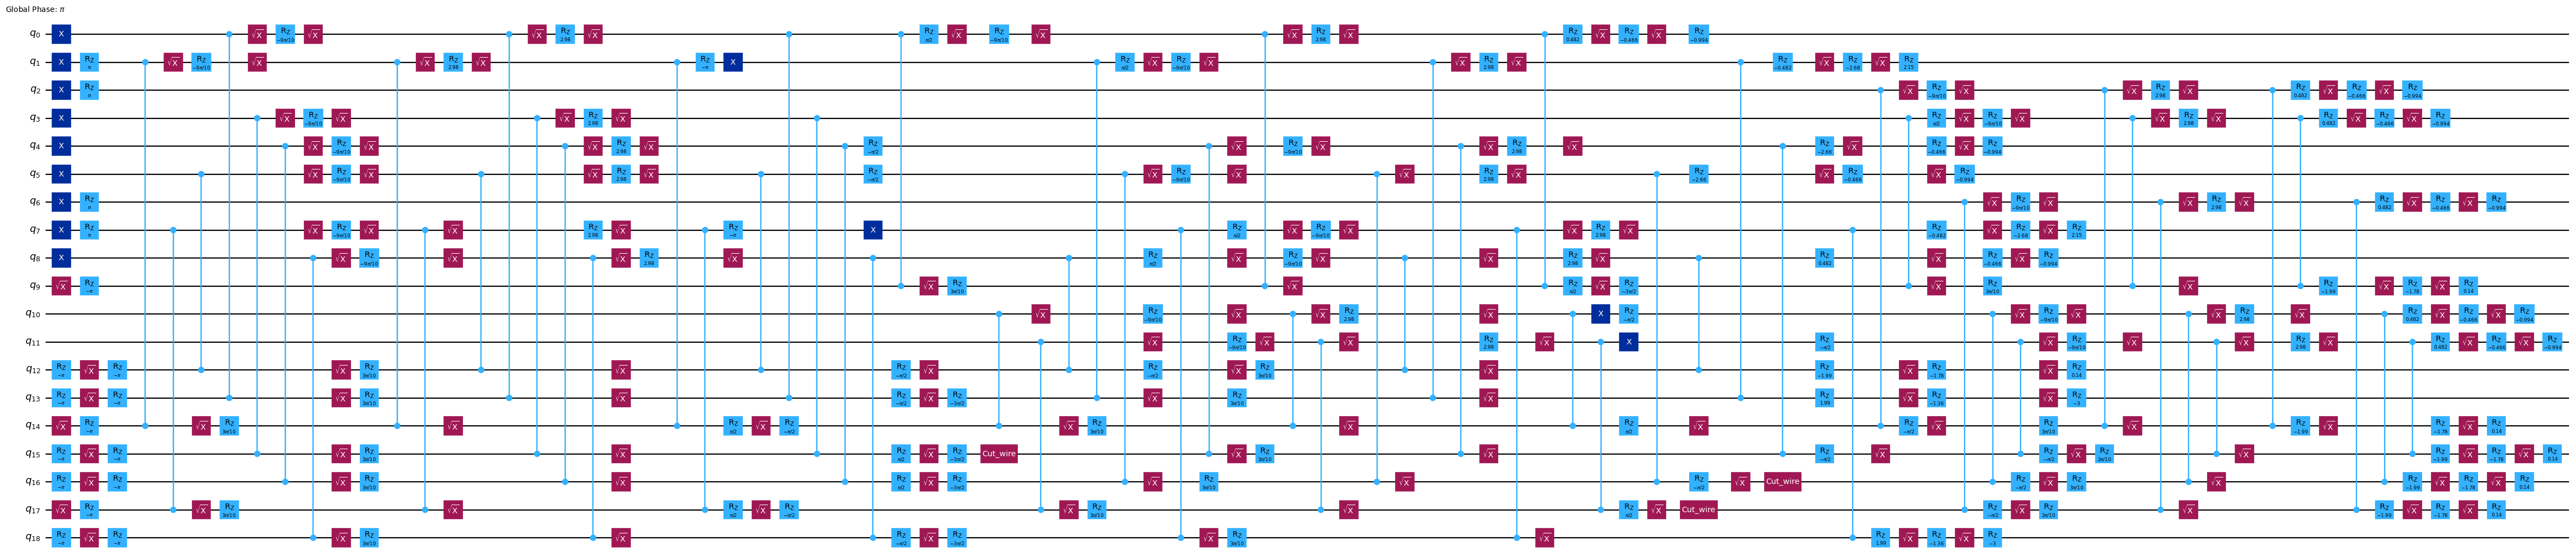

In [135]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_circuit.num_qubits/2)+1)

cut_circuit, metadata = find_cuts(synth_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

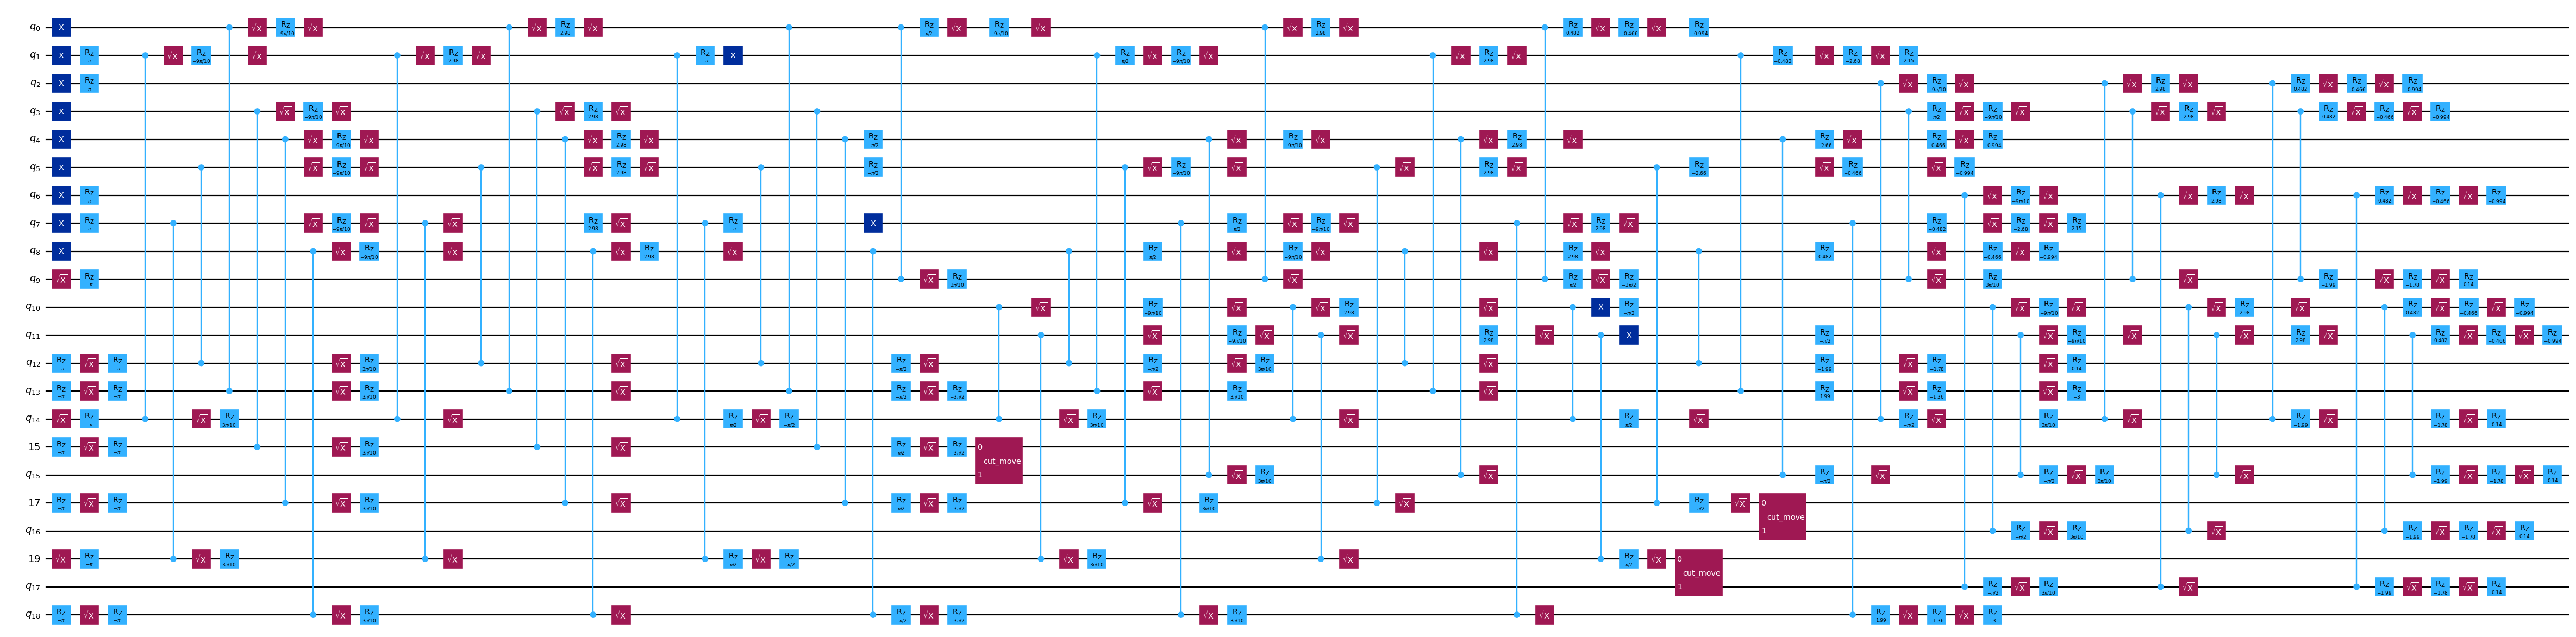

In [136]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [137]:
print(observables_expanded)

['ZIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIII',
 'IIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIII',
 'IIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIII',
 'IIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIII',
 'IIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIII',
 'IIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIII',
 'IIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIZIIIII',
 'IIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIZIII',
 'IIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIZI',
 'IIIIIIIIIIIIIIIIIIIIIZ']


In [138]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 4096.0


In [139]:
subobservables

{0: PauliList(['IIIIIIIIII', 'IIIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIII',
            'IIZIIIIIII', 'IIIZIIIIII', 'IIIIIIIIII', 'IIIIIIIIII',
            'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIIIII', 'IIIIIIIIII',
            'IIIIIIIIII', 'IIIIIIIIII', 'IIIIIIIIII', 'IIIIIIZIII',
            'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']),
 1: PauliList(['ZIIIIIIIII', 'IIIIIIIIII', 'IIIIIIIIII', 'IIIZIIIIII',
            'IIIIIIIIII', 'IIIIIIIIII', 'IIIIZIIIII', 'IIIIIZIIII',
            'IIIIIIIIII', 'IIIIIIIIII', 'IIIIIIZIII', 'IIIIIIIZII',
            'IIIIIIIIII', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'IIIIIIIIII',
            'IIIIIIIIII', 'IIIIIIIIII', 'IIIIIIIIII']),
 2: PauliList(['II', 'ZI', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'II',
            'II', 'II', 'IZ', 'II', 'II', 'II', 'II', 'II', 'II'])}

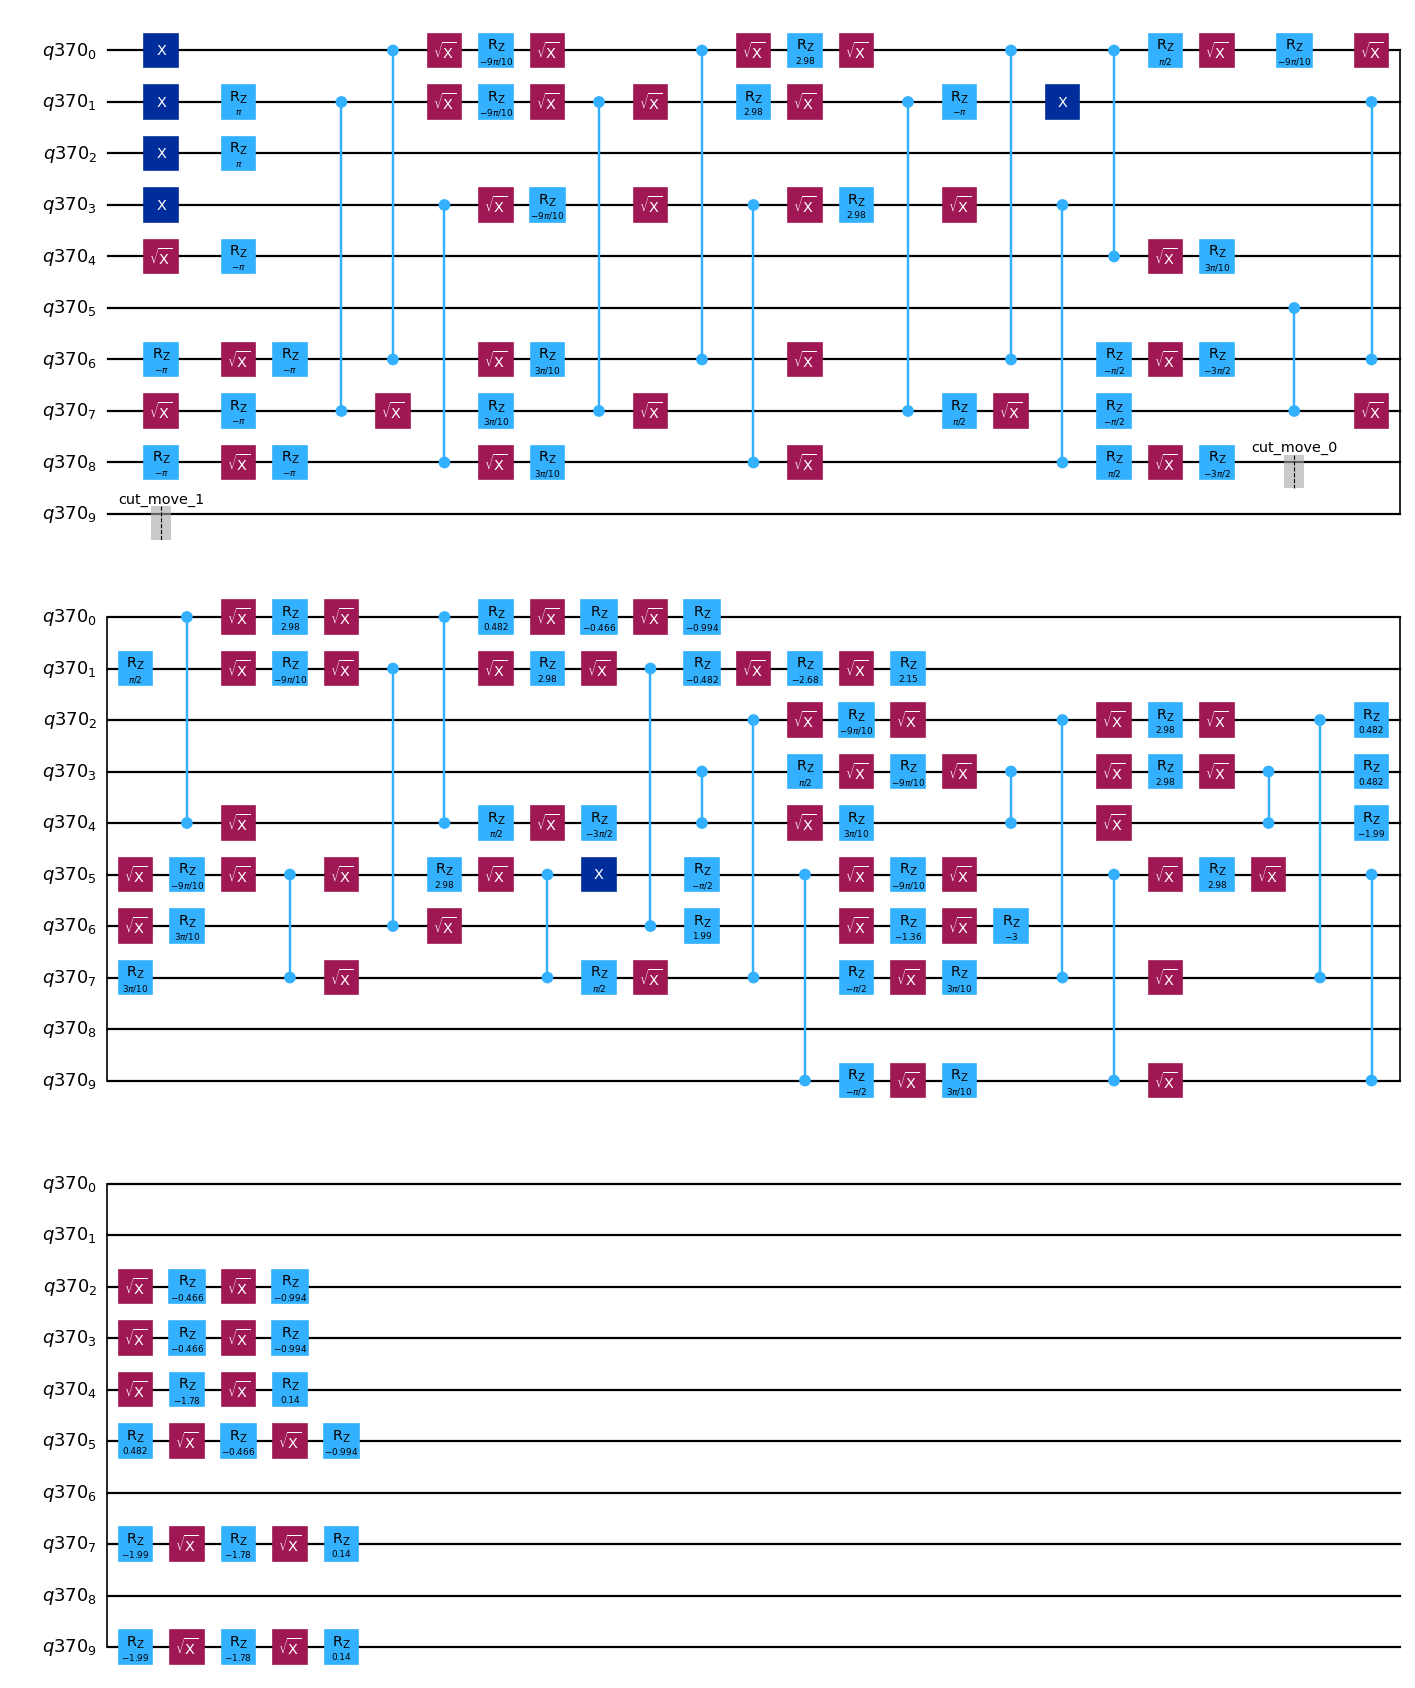

In [140]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

In [141]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
print(f"total subexperiments on the backend is ", total_subexperiments)

total subexperiments on the backend is  1536


### Transpile the cut circuit to the backend

## Same Circuit: Synthesize, Do OBP, Find Cuts and then Transpile

### Draw the circuit

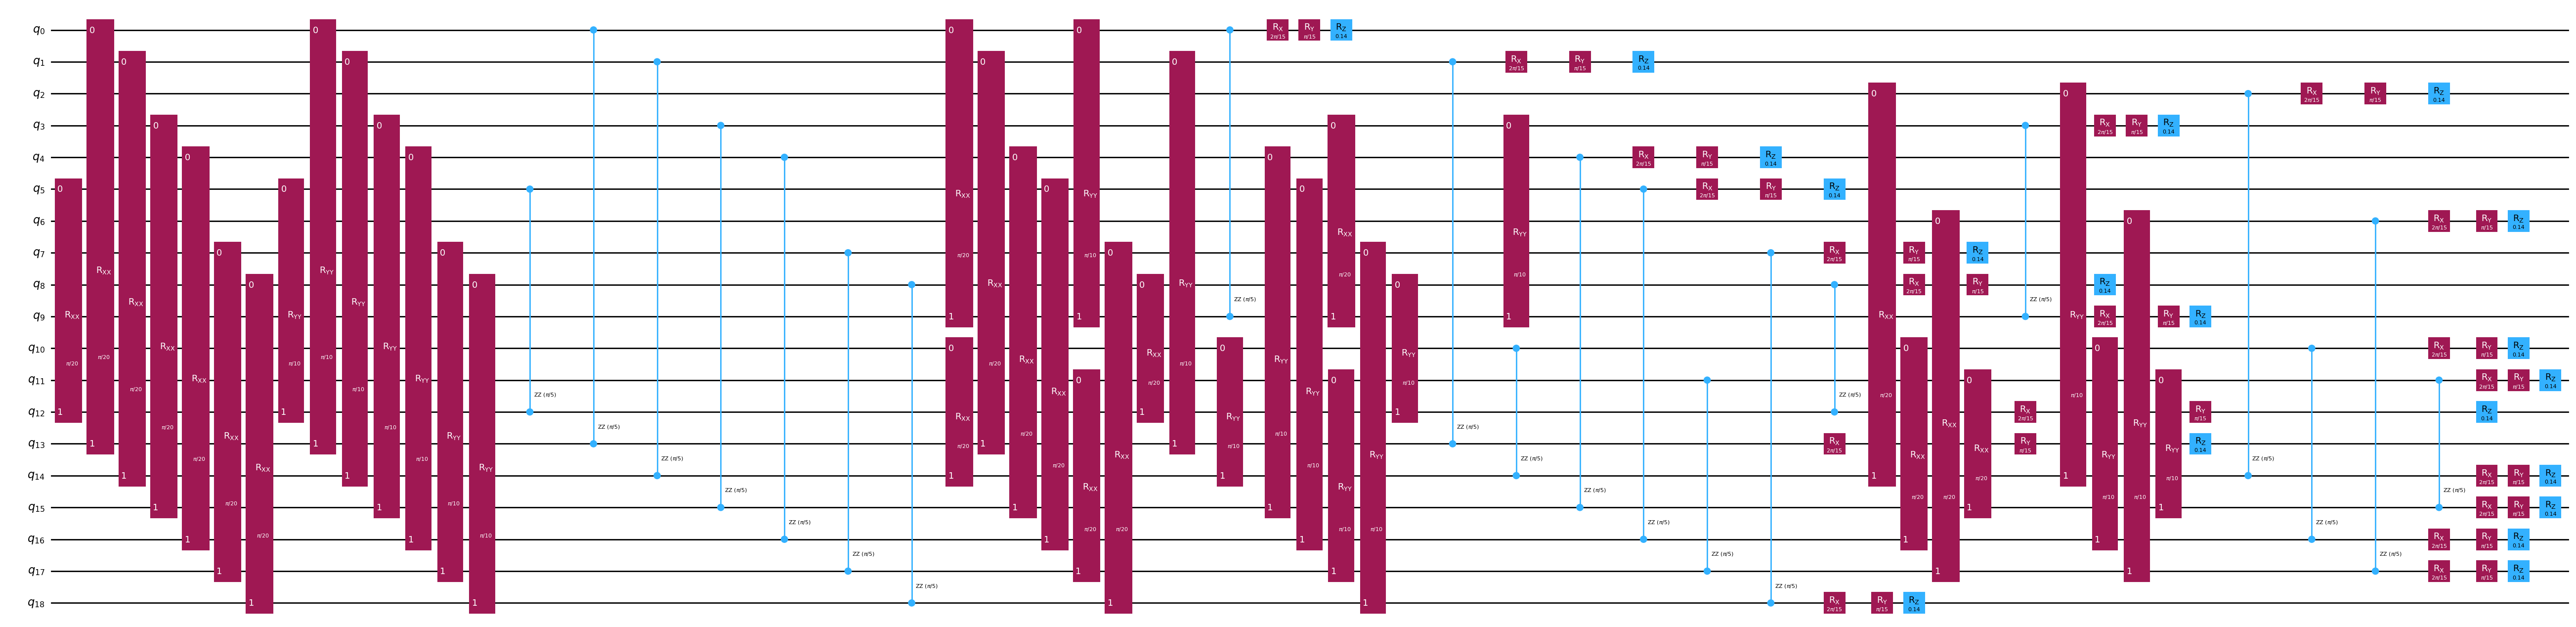

In [143]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices

coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=True)

#reduced_coupling_map = coupling_map.reduce(
#    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18, 7, 17, 11, 15, 3]
#)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=1), time=0.2
)


circuit.draw("mpl", fold = -1)


### Specify an Observable

In [144]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j,
 0.05263158+0.j, 0.05263158+0.j, 0.05263158+0.j])


### Choose a Backend

In [145]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

### Synthesize the Circuit

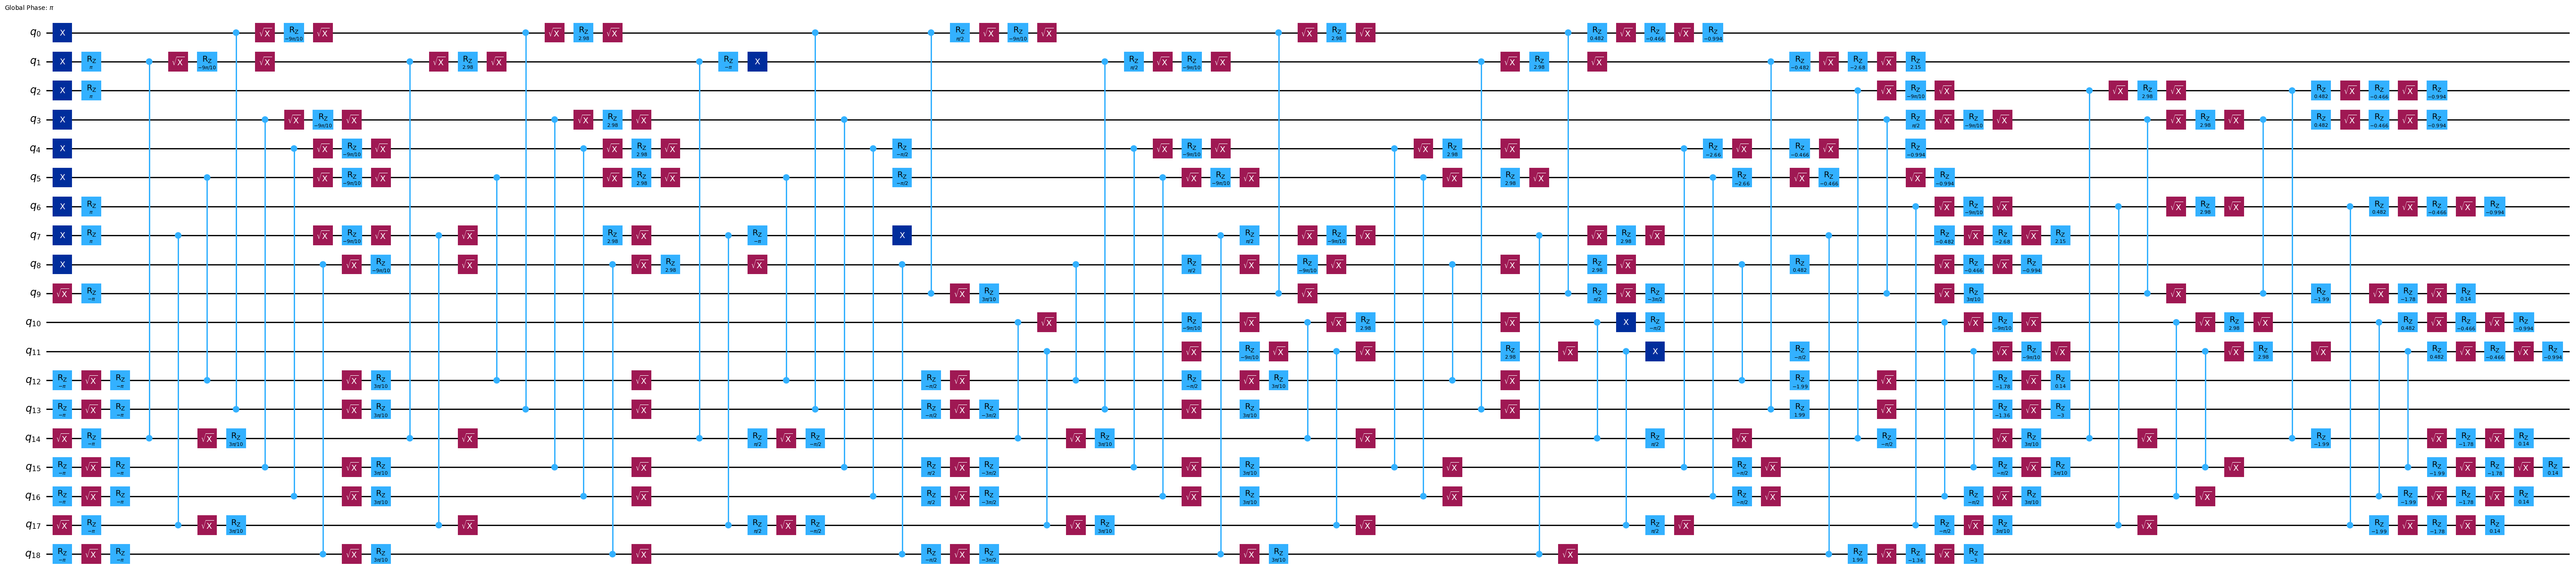

In [147]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl", fold = -1)


### Define max non commuting groups and do slicing

In [159]:
# Define an operator budget list
operator_budget_list =[]
max_qwc_groups_list=range(1,40)
for max_qwc_groups in max_qwc_groups_list:
    op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
    operator_budget_list.append(op_budget)
print(operator_budget_list)
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_circuit, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

[OperatorBudget(max_paulis=None, max_qwc_groups=1, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=2, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=3, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=4, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=5, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=6, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=7, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=8, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=9, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=10, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=11, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=Non

### Do Backpropagation

In [160]:
# Backpropagate without the truncation error budget
bp_circuit_list =[]
commuting_groups_list=[] # Stores the list of the non-commutig groups after backpropagation
backpropagated_observable_list =[]

for op_budget in operator_budget_list:
    backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    )
    # Recombine the slices remaining after backpropagation
    bp_circuit = combine_slices(remaining_slices, include_barriers=False)
    num_non_commuting_groups=backpropagated_observable.group_commuting()
    print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
    bp_circuit_list.append(bp_circuit)
    commuting_groups_list.append(len(num_non_commuting_groups))
    backpropagated_observable_list.append(backpropagated_observable)



Depth of the backpropagated circuit is:  38
Depth of the backpropagated circuit is:  36
Depth of the backpropagated circuit is:  35
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  33
Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circuit is:  18
Depth of the backpropagated circ

In [161]:
bp_circuit_list

In [162]:
commuting_groups_list

[1,
 2,
 3,
 3,
 3,
 3,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 8,
 8,
 8,
 8,
 8,
 8,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14]

In [163]:
bp_circuit.num_qubits

19

### Find cuts on the Backpropagated circuit

In [164]:
# Form the list of cut circuits
bp_cut_circuit_list =[]
bp_num_cuts_list =[]
bp_cut_sampling_overhead_list =[]
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

for bp_circuit in bp_circuit_list:
    # Specify the size of the QPUs available
    device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

    bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
    print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )
    bp_cut_circuit_list.append(bp_cut_circuit)
    bp_num_cuts_list.append(len(bp_cut_metadata["cuts"]))
    bp_cut_sampling_overhead_list.append(bp_cut_metadata["sampling_overhead"])


print(bp_cut_circuit_list)
print(bp_num_cuts_list)
print(bp_cut_sampling_overhead_list)

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 4096.0.

Found solution using 3 cuts with a sampling overhead of 1296.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampling overhead of 16.0.

Found solution using 1 cuts with a sampli

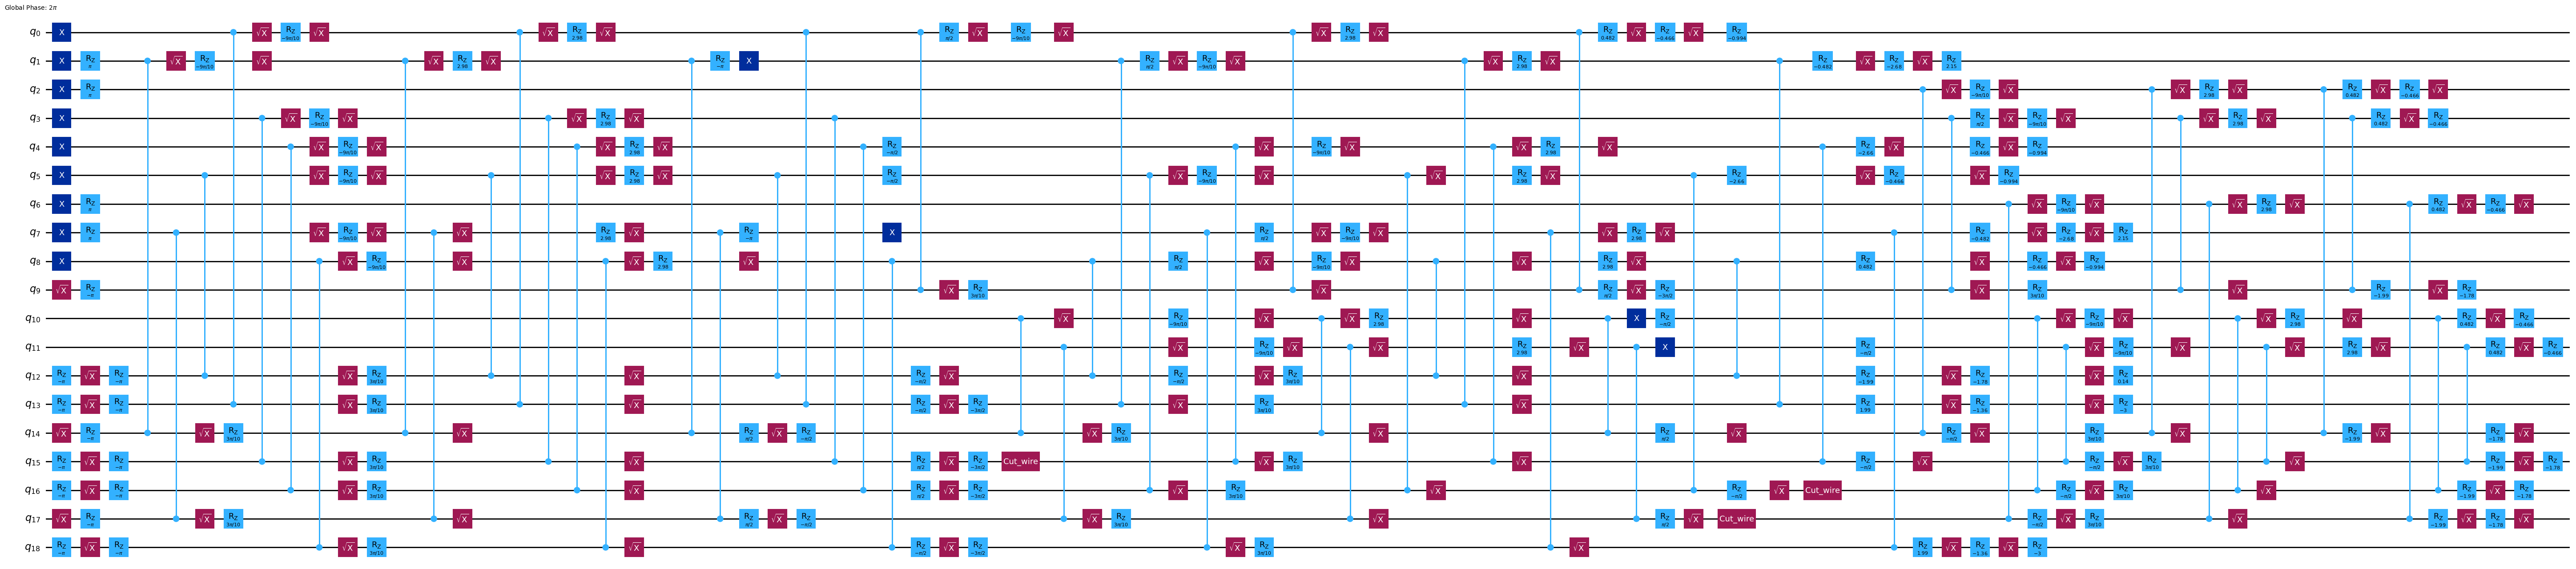

In [165]:
bp_cut_circuit_list[0].draw("mpl", fold =-1)

In [166]:
from qiskit_addon_cutting import cut_wires, expand_observables
qc_w_ancilla_list=[]
observables_expanded_list=[]
for cut_ckt, bp_obs, bp_ckt in zip(bp_cut_circuit_list, backpropagated_observable_list, bp_circuit_list):
    qc_w_ancilla = cut_wires(cut_ckt)
    observables_expanded = expand_observables(bp_obs.paulis, bp_ckt, qc_w_ancilla)
    qc_w_ancilla_list.append(qc_w_ancilla)
    observables_expanded_list.append(observables_expanded)
    
    
    #qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)
print(qc_w_ancilla_list)
#print(observables_expanded_list)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30fd24bc0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3879f7f80>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x38739c170>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x17e69c5f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3888391f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x163b4df70>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x38504cc20>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3837c1220>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x386441ee0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3861c5760>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3879c77d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x382d1b710>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1602670e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3864e4200>, <qiskit.circuit.qua

In [167]:
from qiskit_addon_cutting import partition_problem

subcircuits_list =[]
subobservables_list =[]
for qc_w_anc, obs_expan in zip(qc_w_ancilla_list, observables_expanded_list):

    partitioned_problem = partition_problem(
        circuit=qc_w_anc, observables=obs_expan
    )
    subcircuits = partitioned_problem.subcircuits
    subobservables = partitioned_problem.subobservables
    print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
    )
    subcircuits_list.append(subcircuits)
    subobservables_list.append(subobservables)
    #subcircuits[1].draw("mpl")
print(subcircuits_list)
print(subobservables_list)

Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 4096.0
Sampling overhead: 1296.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 16.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
[{0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30ff765a0

In [168]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments_list =[]

for subckt, subobs in zip(subcircuits_list, subobservables_list):
    subexperiments, coefficients = generate_cutting_experiments(
        circuits=subckt, observables=subobs, num_samples=np.inf
    )
    total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
    subexperiments_list.append(total_subexperiments)

print(subexperiments_list)

[1536, 3072, 4096, 6144, 6144, 6144, 4032, 192, 192, 192, 216, 216, 216, 216, 216, 216, 216, 156, 156, 156, 156, 156, 156, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]


### Transpile the backpropagated circuit to the backend

In [ ]:
"""backend=FakeTorino()
isa_subexperiments_list =[]
for subexperiments in subexperiments_list:
    # Transpile the subexperiments to ISA circuits
    pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
    isa_subexperiments = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
    }
    isa_subexperiments_list.append(isa_subexperiments)
    print(isa_subexperiments_list)"""

In [ ]:
"""from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    job0 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[0].items()
    }

    job1 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[1].items()
    }

    job2 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[2].items()
    }

    job3 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[3].items()
    }

    job4 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[4].items()
    }

    job5 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[5].items()
    }

    job6 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[6].items()
    }

    job7 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[7].items()
    }

    job8 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[8].items()
    }

    job9 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[9].items()
    }"""

In [ ]:
"""# Retrieve results
results0 = {label: job.result() for label, job in job0.items()}
results1= {label: job.result() for label, job in job1.items()}
results2 = {label: job.result() for label, job in job2.items()}
results3 = {label: job.result() for label, job in job3.items()}
results4 = {label: job.result() for label, job in job4.items()}
results5 = {label: job.result() for label, job in job5.items()}
results6 = {label: job.result() for label, job in job6.items()}
results7 = {label: job.result() for label, job in job7.items()}
results8 = {label: job.result() for label, job in job8.items()}
results9 = {label: job.result() for label, job in job9.items()}"""

In [ ]:
"""
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
"""

In [ ]:
"""
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)
"""

## Scratch Pad

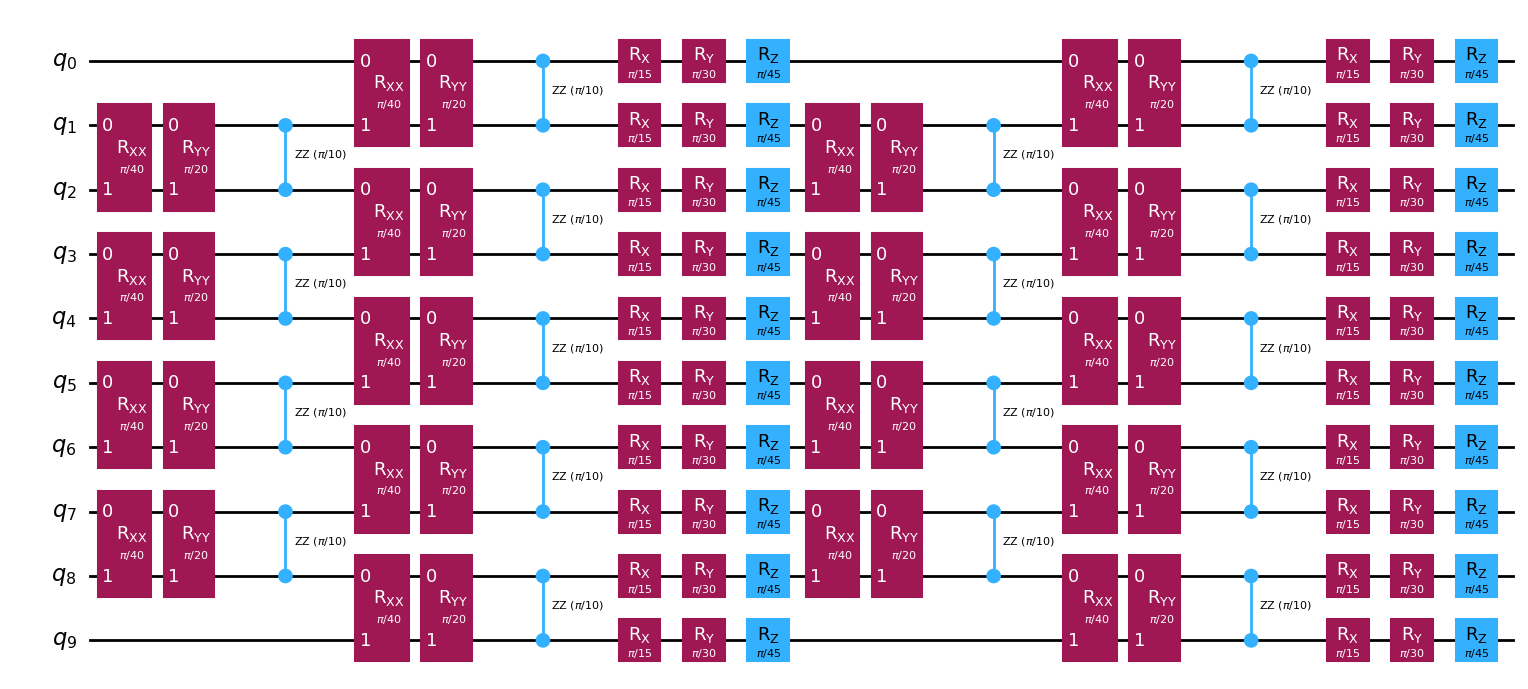

In [255]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)


circuit.draw("mpl")

In [256]:
# Specify a single-qubit observable
observable = SparsePauliOp('ZIIIIIIIII')
print(observable)

SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])


In [257]:
backend=FakeTorino()

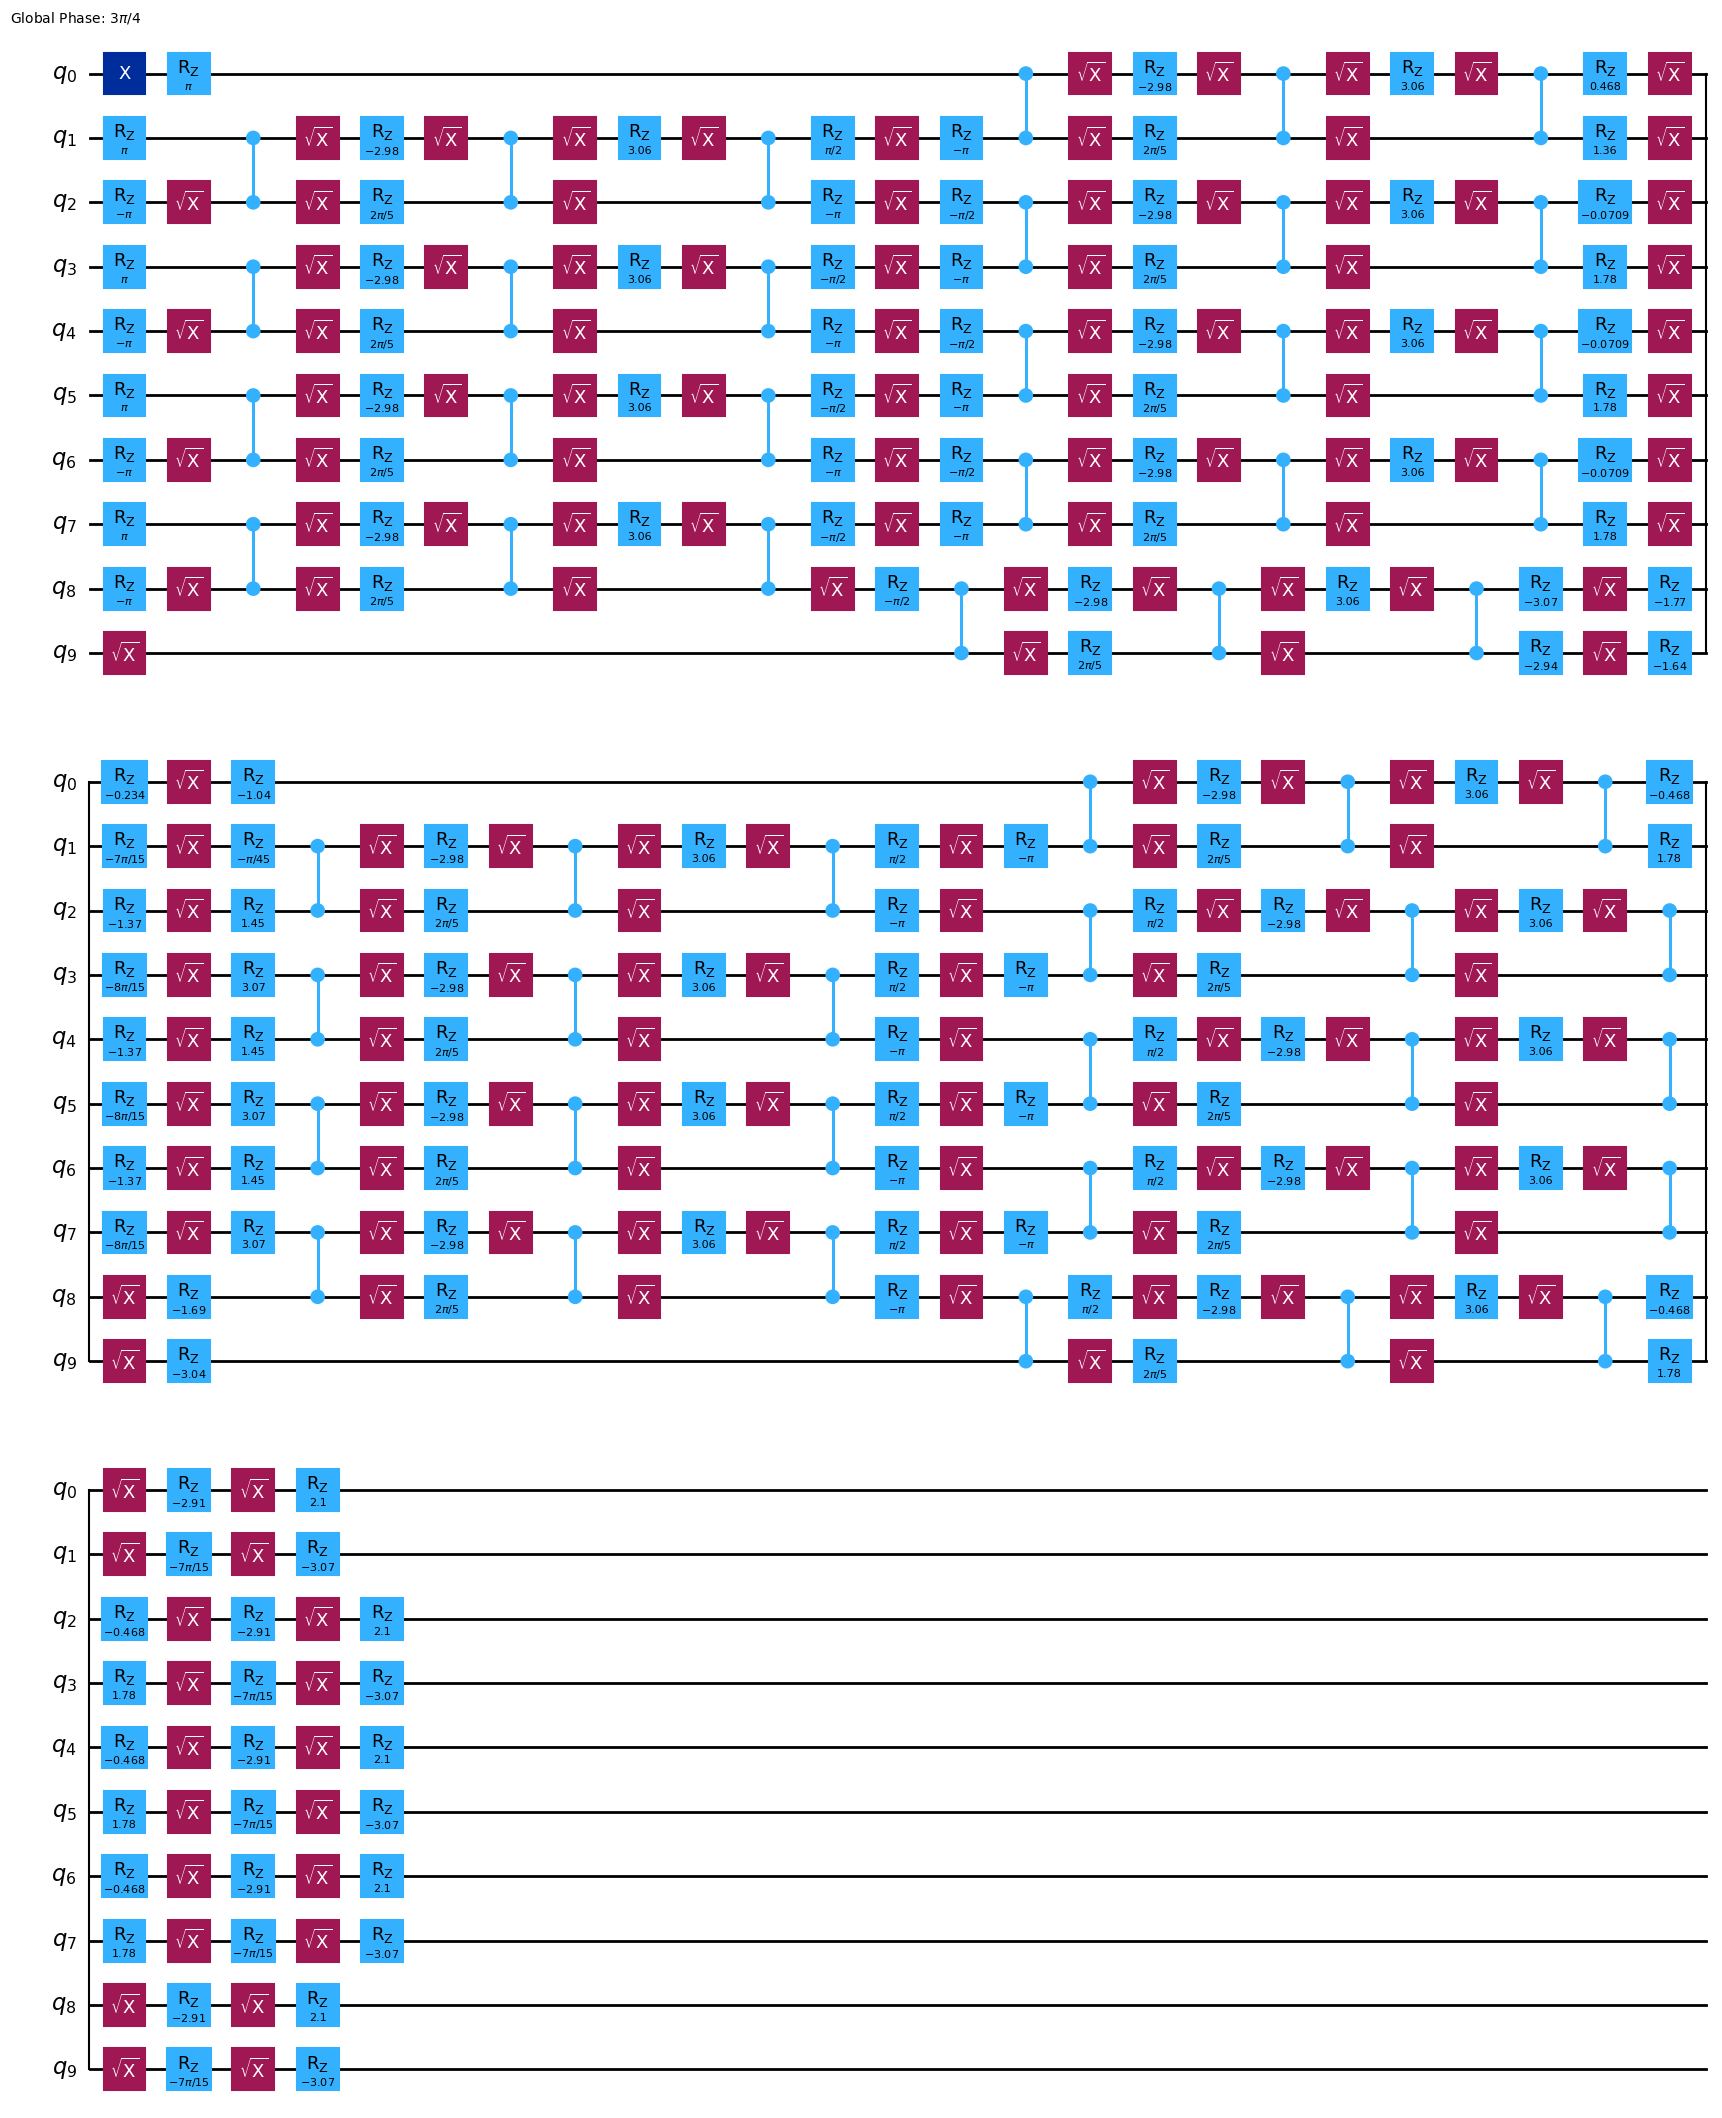

In [258]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

Found solution using 4 cuts with a sampling overhead of 11664.0.
Lowest cost solution found: True.
Gate Cut at circuit instruction index 145
Gate Cut at circuit instruction index 151
Gate Cut at circuit instruction index 156
Wire Cut at circuit instruction index 260


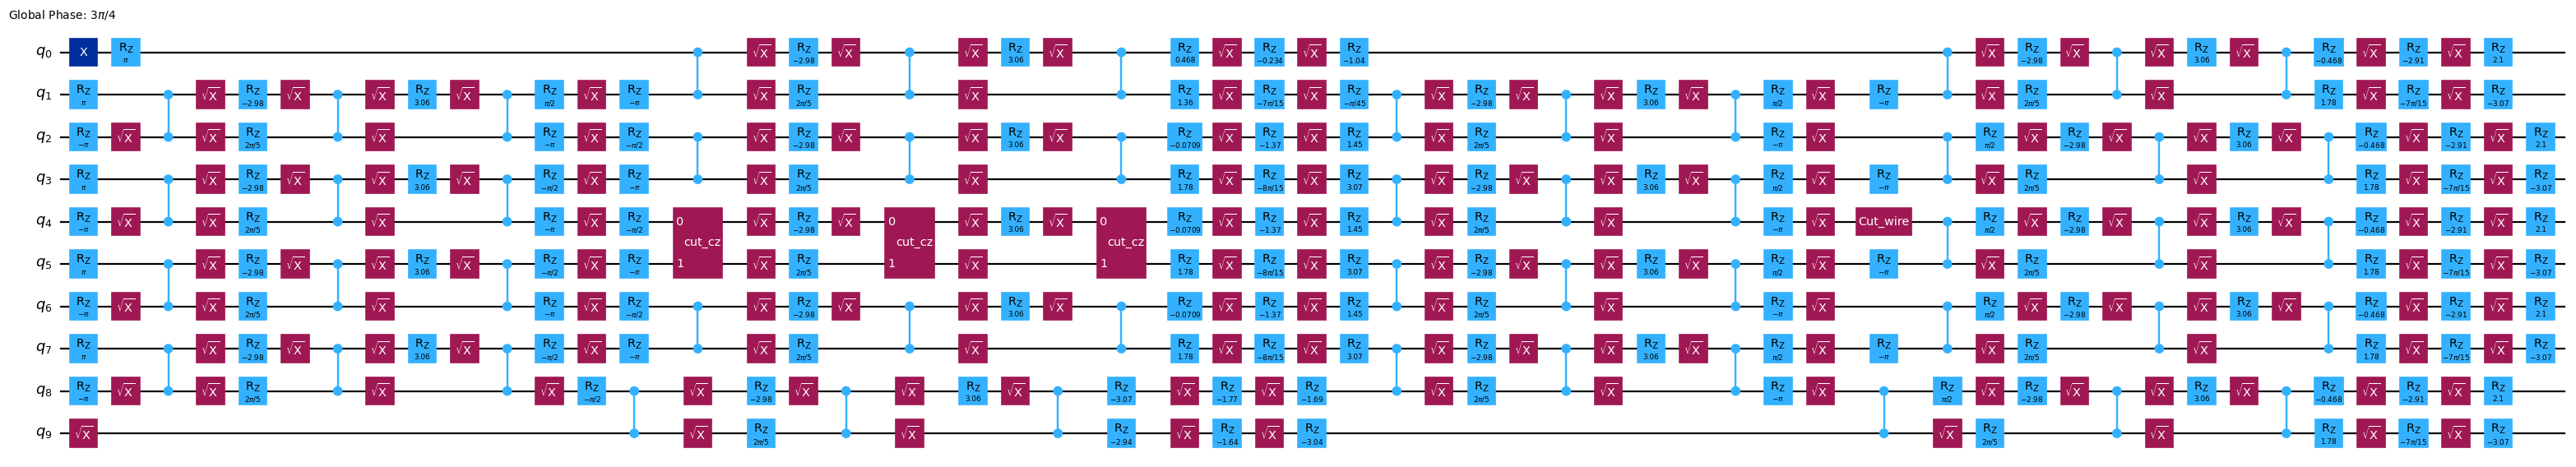

In [259]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_circuit.num_qubits/2)+1)

cut_circuit, metadata = find_cuts(synth_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

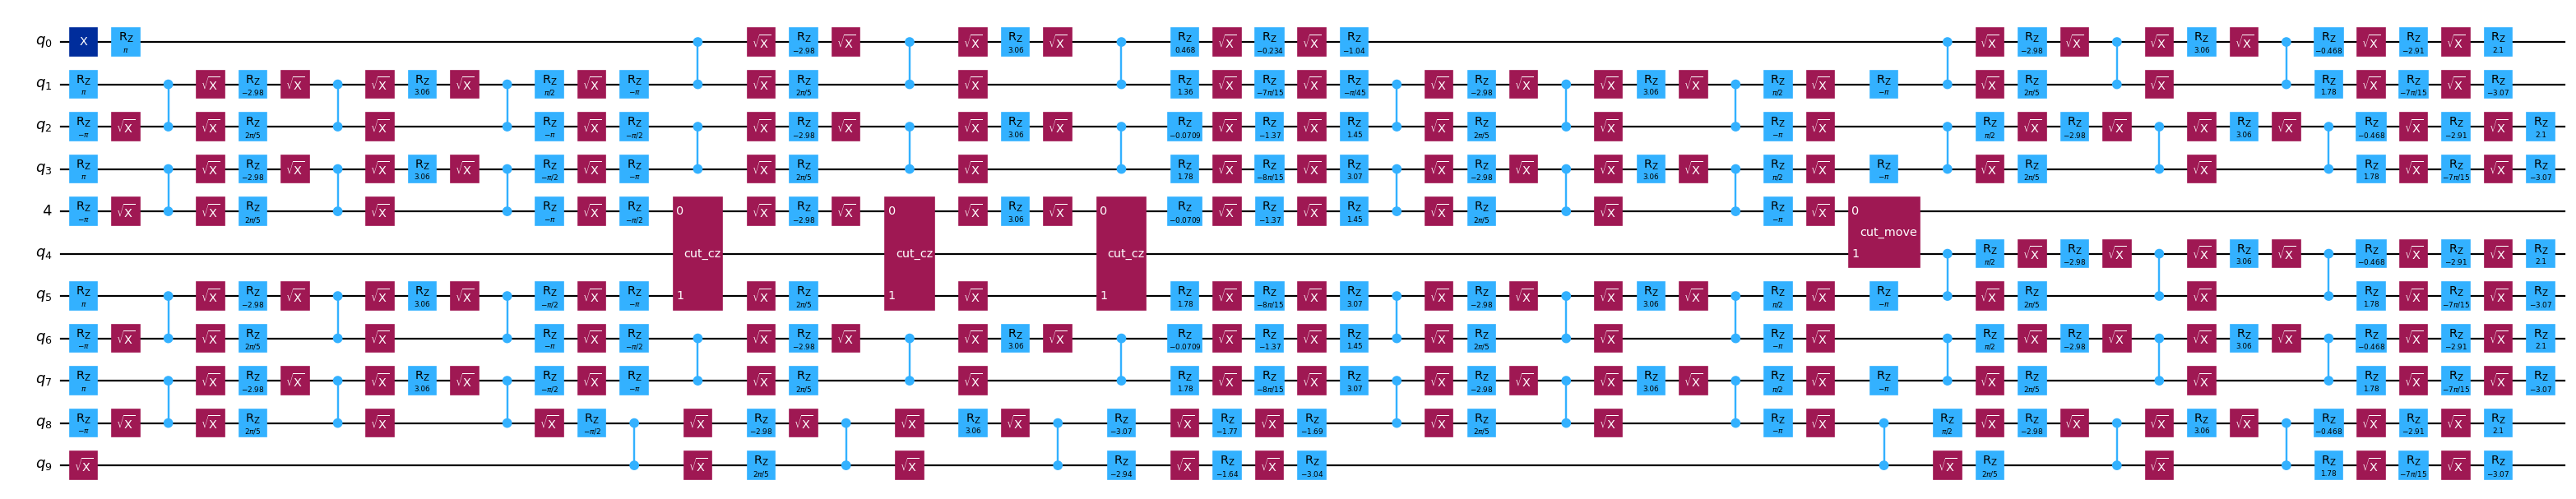

In [260]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [261]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 11664.0


In [262]:
from qiskit_addon_cutting import generate_cutting_experiments
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

3456 total subexperiments to run on backend.


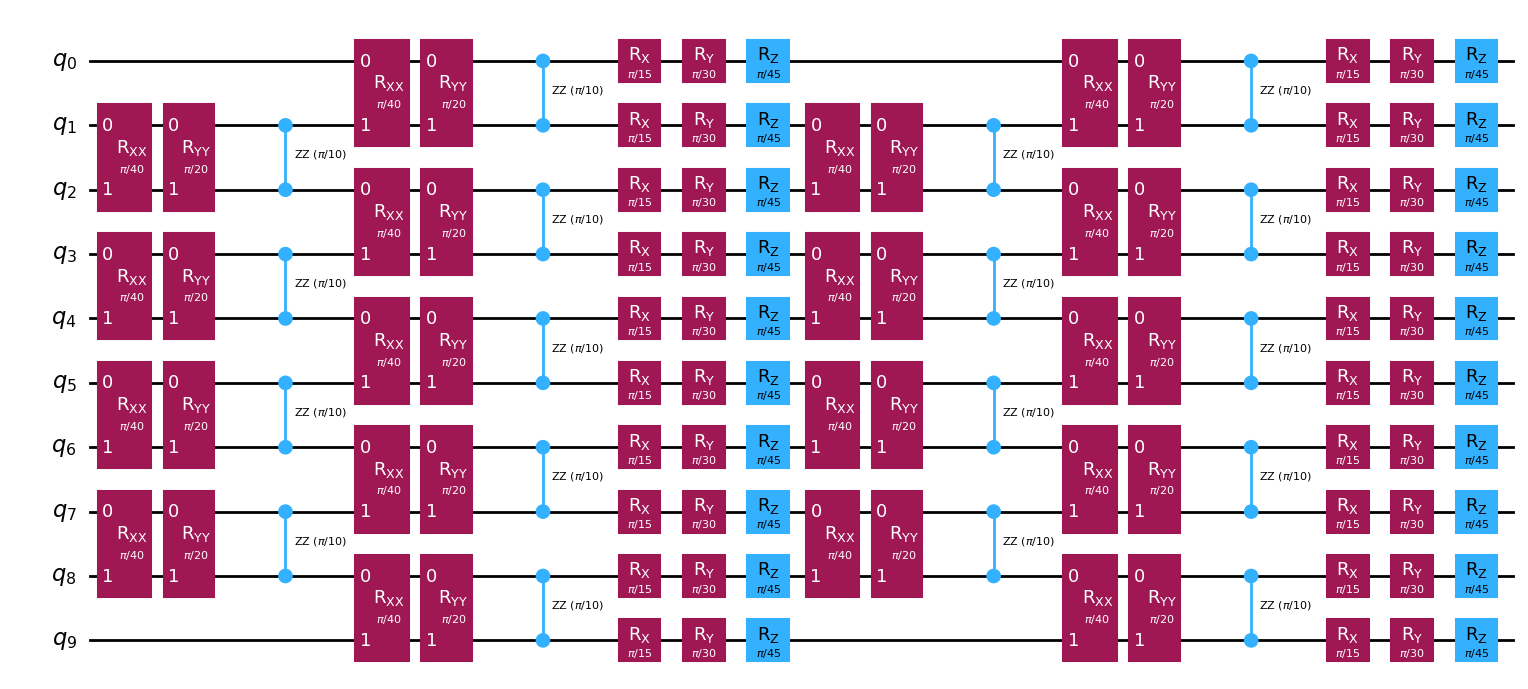

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)


circuit.draw("mpl")

In [2]:
# Specify a single-qubit observable
observable = SparsePauliOp('ZIIIIIIIII')
print(observable)

SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])


In [3]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

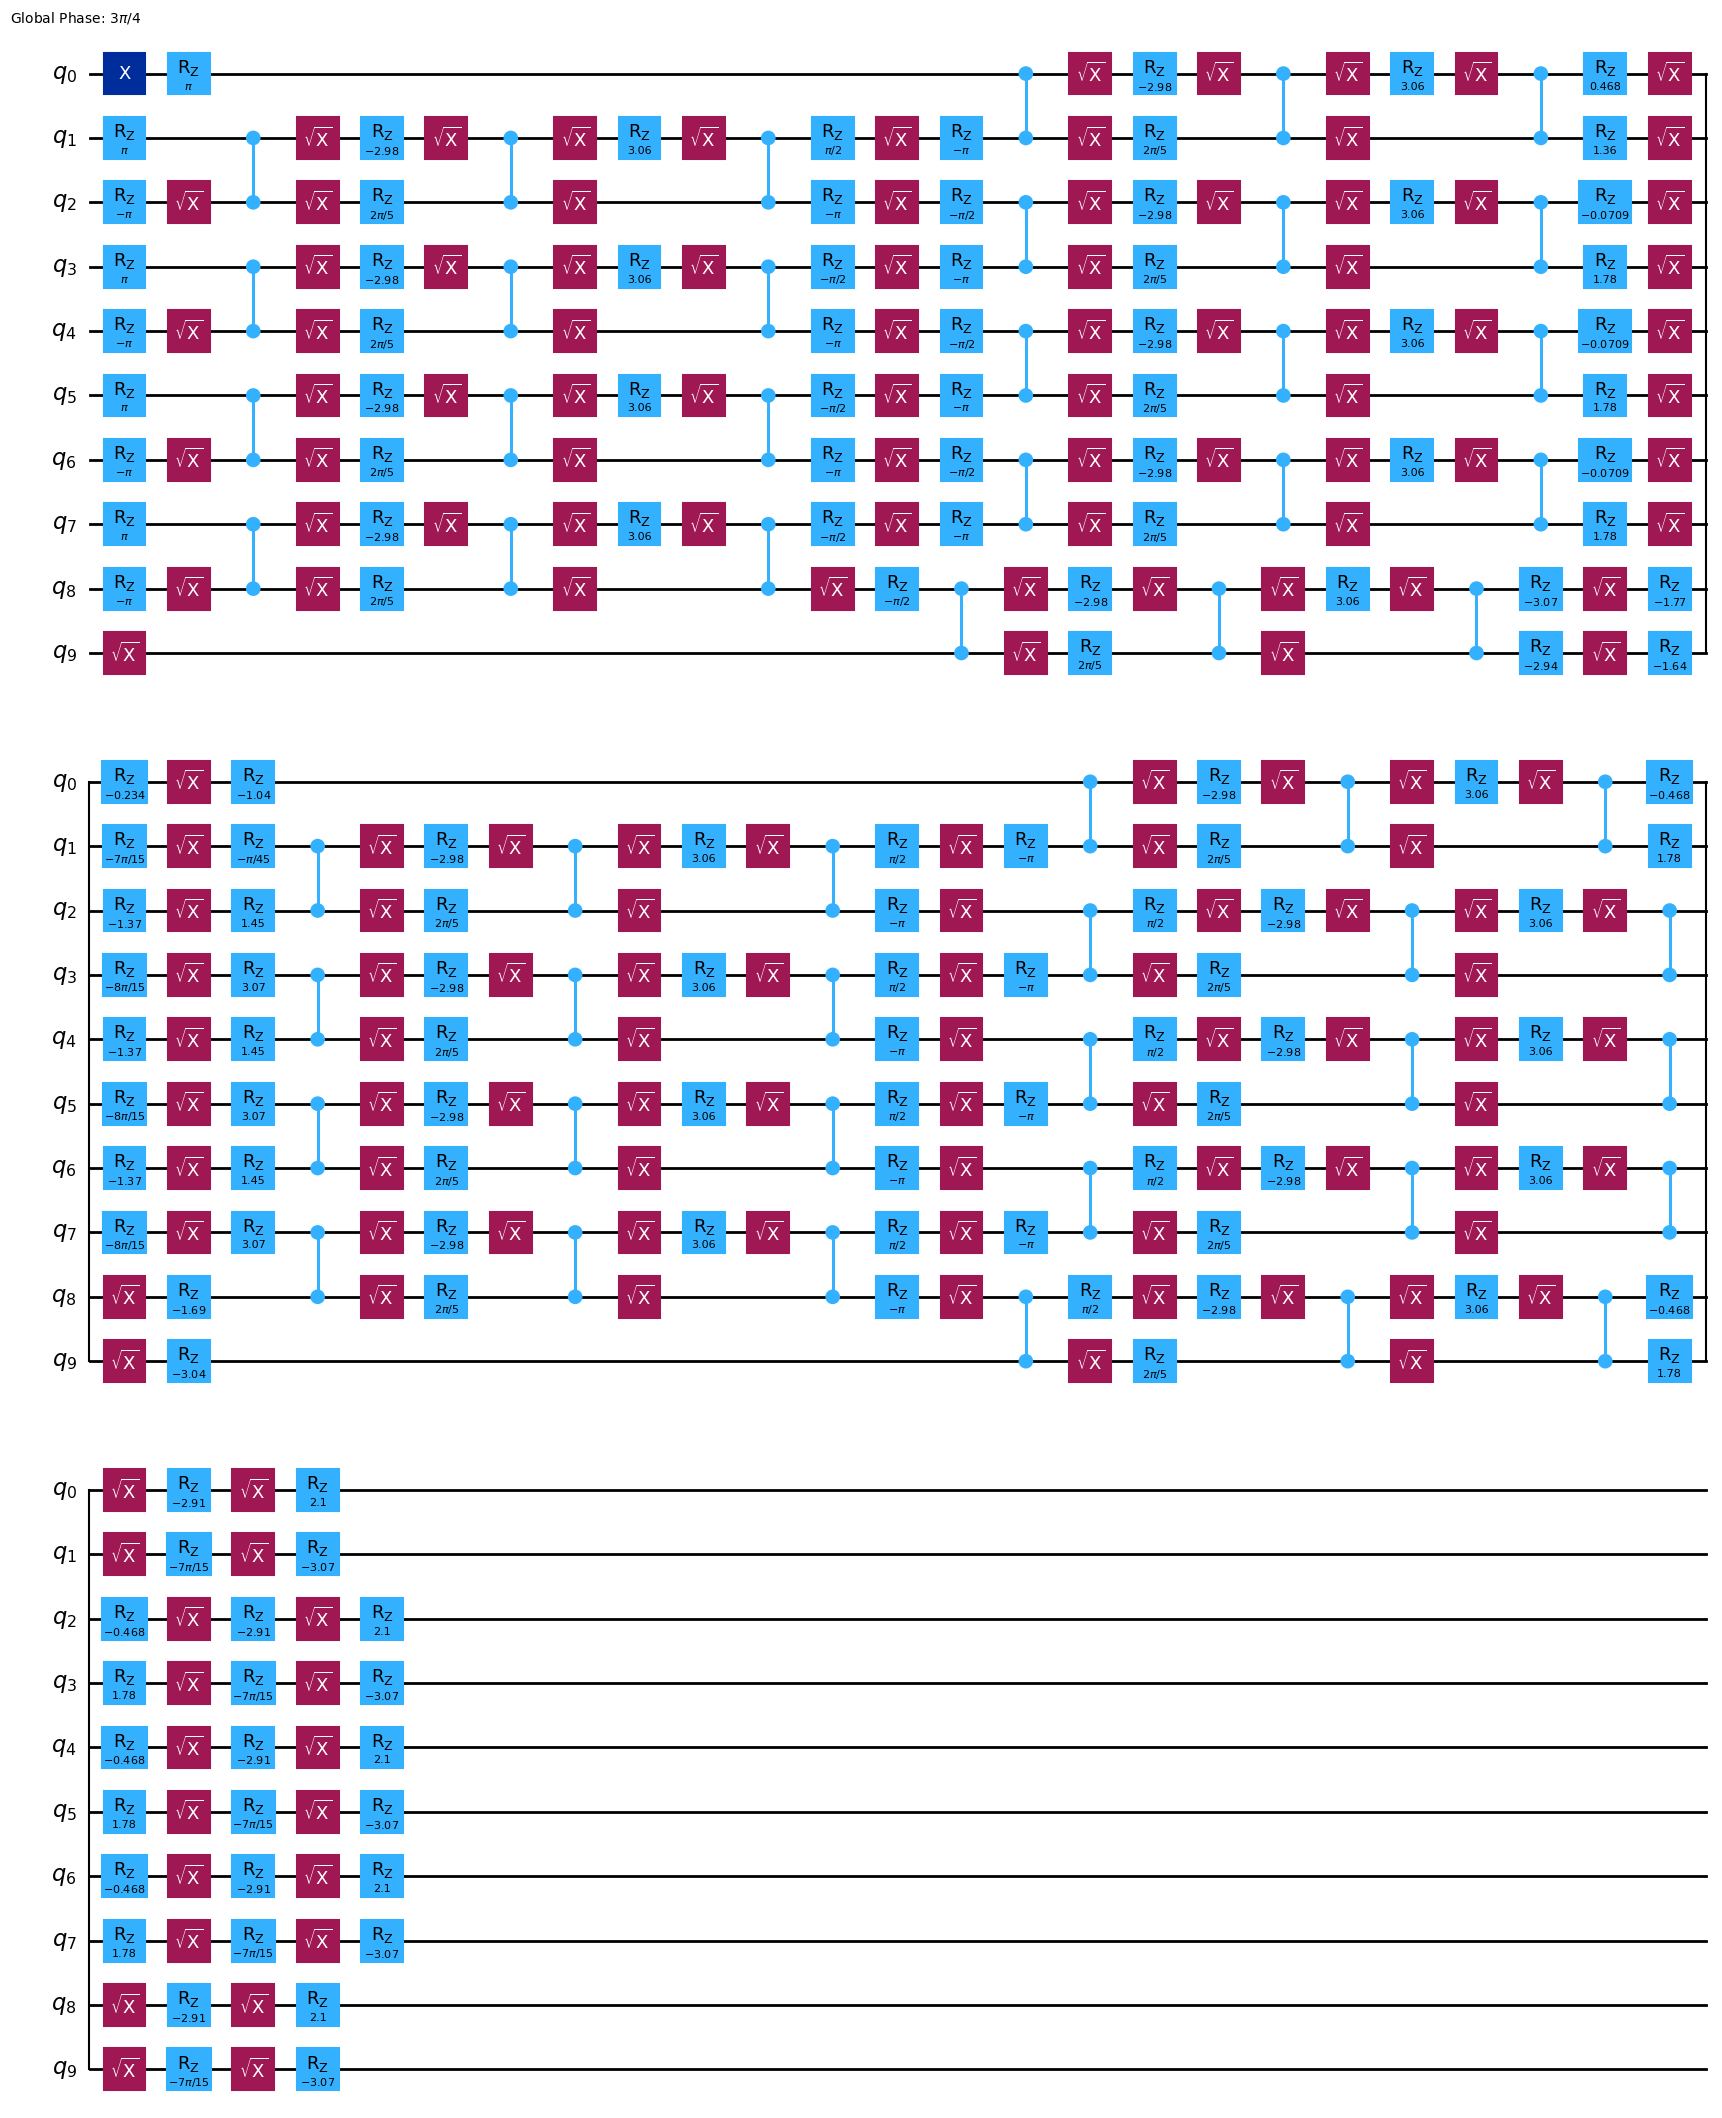

In [4]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

In [ ]:
# Define an operator budget list
op_budget = OperatorBudget(max_qwc_groups=3)

In [5]:
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_circuit, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 55 slices.


In [ ]:
# Backpropagate without the truncation error budget

backpropagated_observable, remaining_slices, metadata = backpropagate(
observable,
synthesized_slices,
operator_budget=op_budget
)
# Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=False)
num_non_commuting_groups=backpropagated_observable.group_commuting()
print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
print(f"The non commuting groups are: ",num_non_commuting_groups)
print(f"The number of non commuting groups is: ", len(num_non_commuting_groups))


AttributeError: 'NoneType' object has no attribute 'depth'

Found solution using 3 cuts with a sampling overhead of 2304.0.

Wire Cut at circuit instruction index 126
Wire Cut at circuit instruction index 207
Gate Cut at circuit instruction index 223


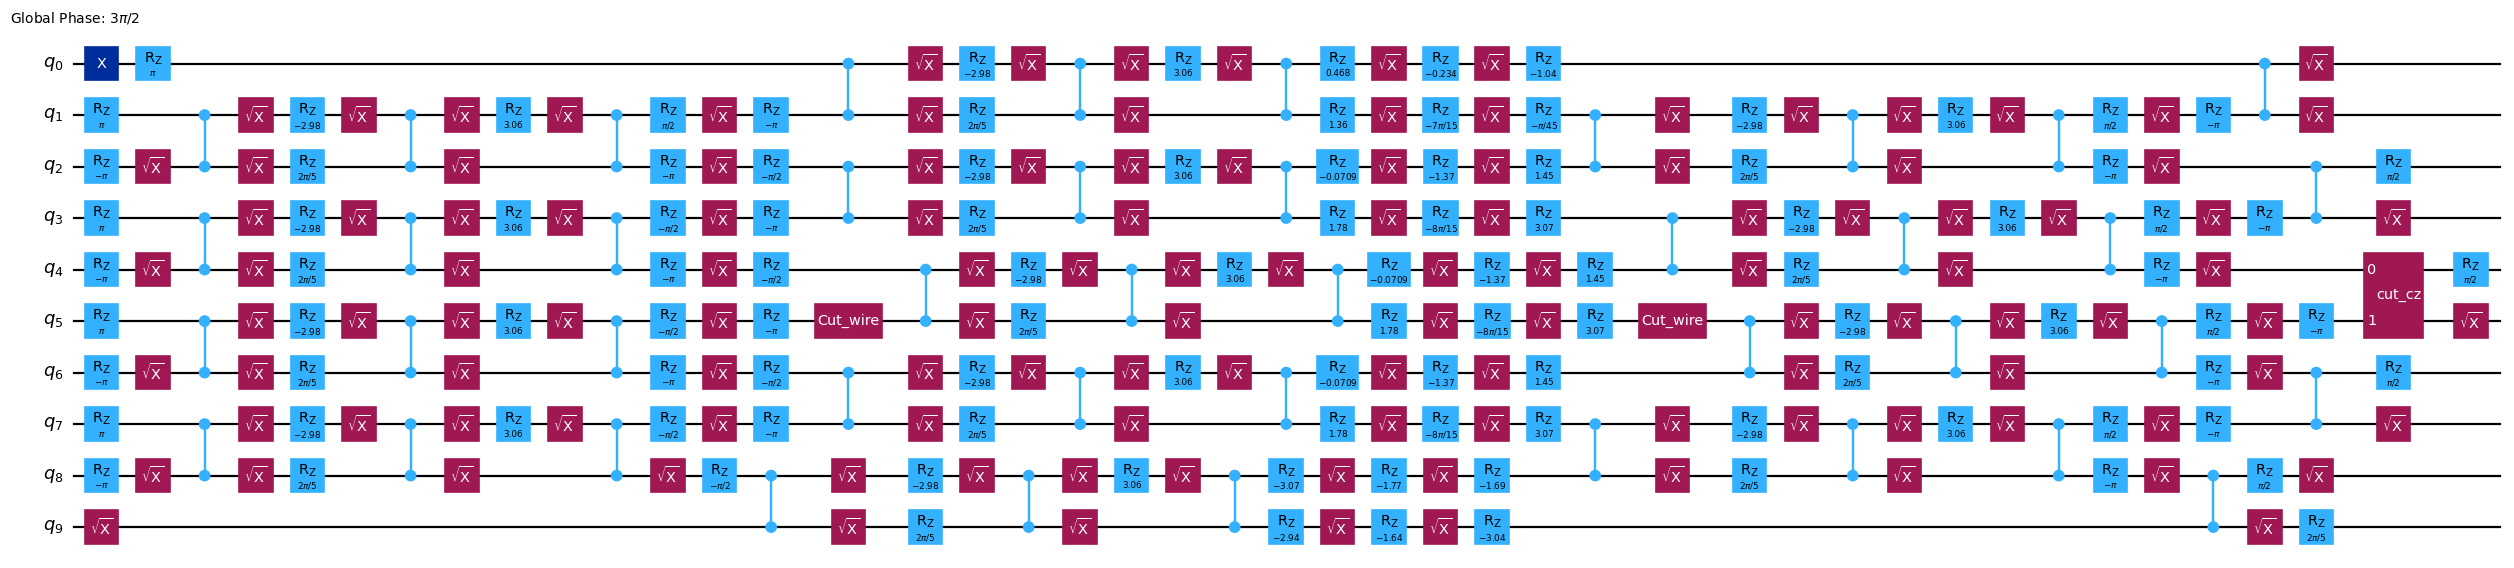

In [272]:
# Form the list of cut circuits
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
    f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
    #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
)
for cut in bp_cut_metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
bp_cut_circuit.draw("mpl", scale=0.8, fold=-1)

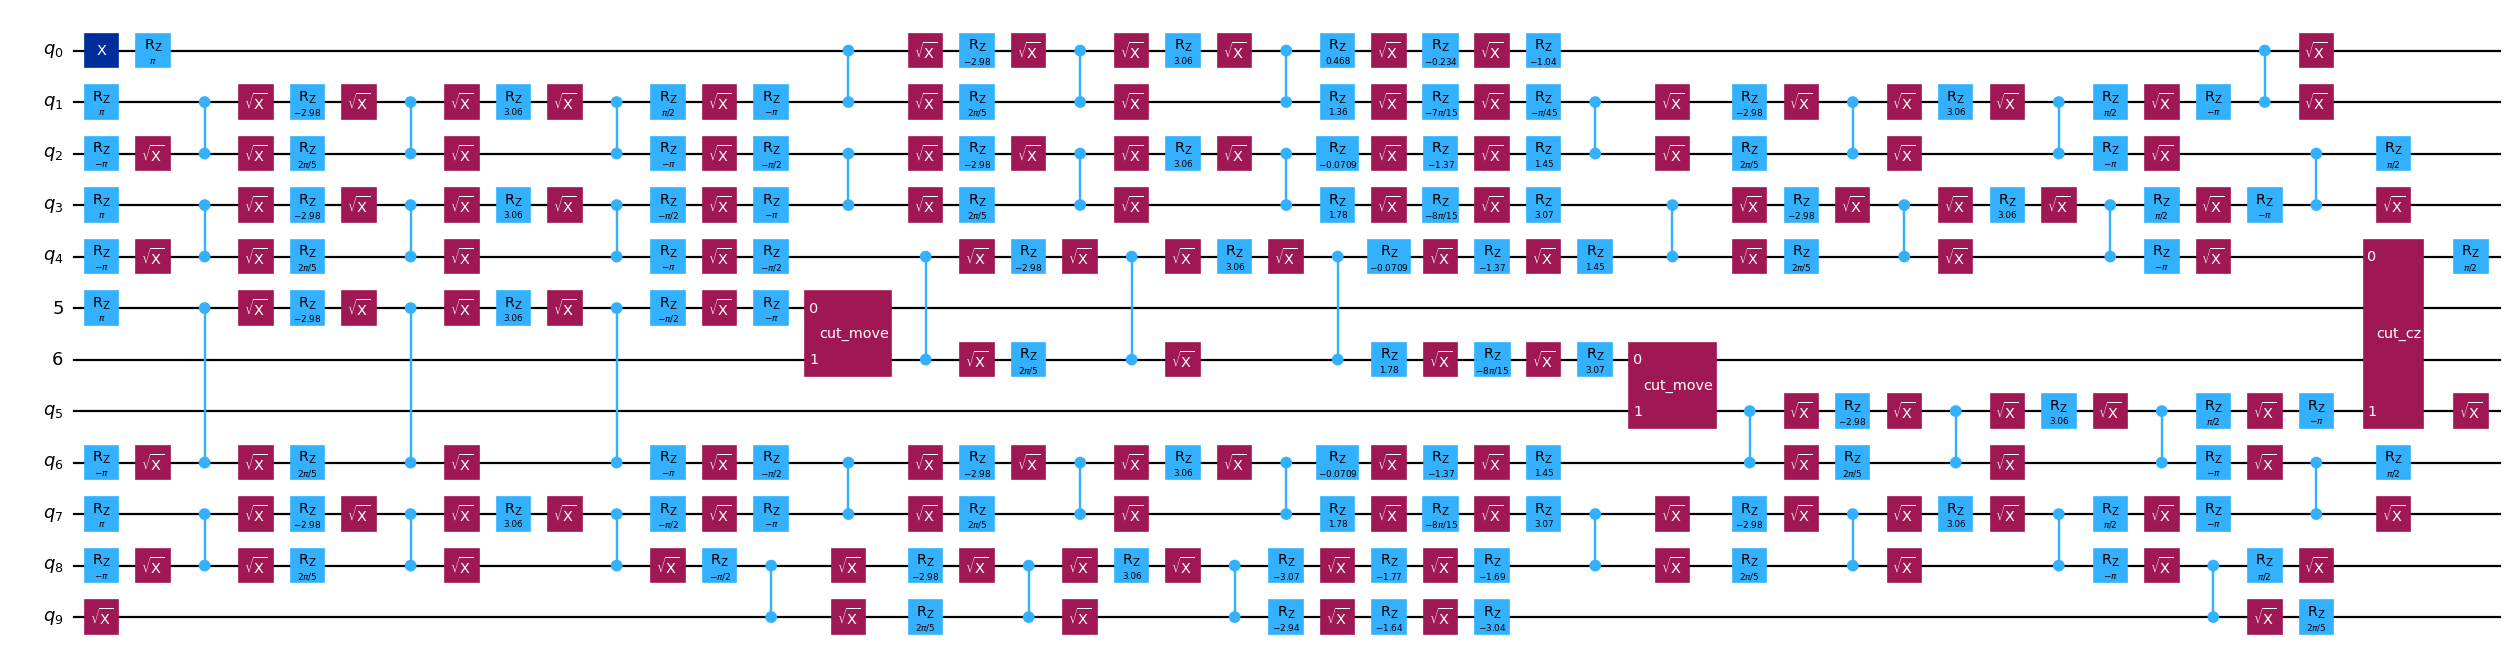

In [273]:
from qiskit_addon_cutting import cut_wires, expand_observables


qc_w_ancilla = cut_wires(bp_cut_circuit)
observables_expanded = expand_observables(backpropagated_observable.paulis, bp_circuit, qc_w_ancilla)
qc_w_ancilla_list.append(qc_w_ancilla)
observables_expanded_list.append(observables_expanded)
    
    
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)


Sampling overhead: 2304.0


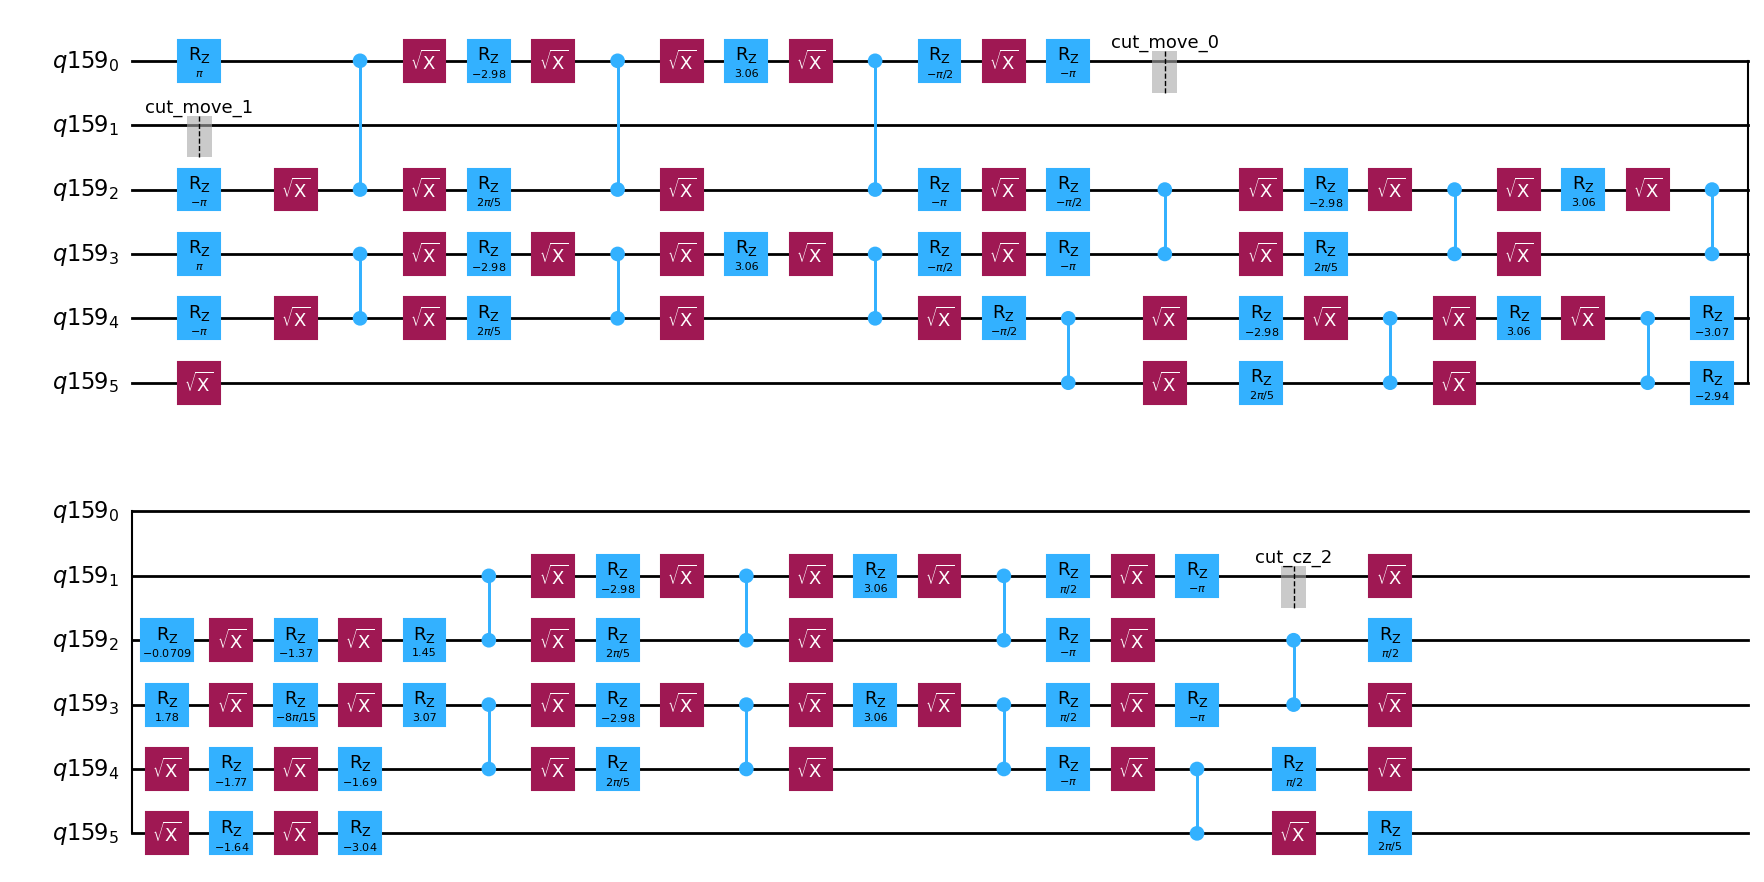

In [274]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)
subcircuits[1].draw("mpl")

In [275]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

2688 total subexperiments to run on backend.


In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)


circuit.draw("mpl")

In [ ]:
# Specify a single-qubit observable
observable = SparsePauliOp('ZIIIIIIIII')
print(observable)

In [ ]:
backend=FakeTorino()

In [ ]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

In [ ]:
# Define an operator budget list
op_budget = OperatorBudget(max_qwc_groups=4)